In [3]:
import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# from statsmodels.api import OLS, add_constant, qqplot
# from statsmodels.tsa.ar_model import AutoReg, ar_select_order
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

# from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import cufflinks as cf
import chart_studio.plotly as py
# import plotly.graph_obs as go
cf.set_config_file(world_readable=True, theme='pearl', offline=True)

cf.go_offline()

plt.rcParams['figure.figsize'] = (14,6)

In [2]:
#!pip3.9 install pmdarima

     |████████████████████████████████| 600 kB 535 kB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 8.5 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [4]:
def plot_plotly(df,title):
    df.iplot(title=title, xTitle='time period', yTitle='temperatture')

## LOAD THE DATA

Data from Murmansk, daily mean temperature 

In [7]:
df = pd.read_csv('Murmansk_mean.txt')

df = df.drop(['STAID', ' SOUID'], axis=1)
df = df.rename(columns={'    DATE': "DATE", '   TG': "MEAN", ' Q_TG':"Q_TG_MEAN"})

df['DATE']=pd.to_datetime(df['DATE'], format='%Y%m%d', errors='ignore')
df['YEAR'] = pd.DatetimeIndex(df['DATE']).year
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
df.loc[df['Q_TG_MEAN']==9, 'MEAN']=float('Nan')
df['MEAN']=df['MEAN']/10

df = df.drop(['Q_TG_MEAN'], axis=1)

df['MEAN']=df['MEAN']+20
df[df['MEAN'].isna()]

df=df.set_index('DATE')
df = df[df.YEAR < 2017]


Create DF with mean temperature per month, set index as datetime

In [8]:
df = df.groupby(['YEAR','MONTH'])['MEAN'].mean()
df = df.to_frame()
df['DAY']=[1]*len(df)
df=df.reset_index()
df['index']=pd.to_datetime(df['YEAR']*10000+df['MONTH']*100+df['DAY'],format='%Y%m%d')
df=df.set_index(['index'])

Drop years with NaN data and 2015 for our test data 

In [9]:
df_test = df[df.YEAR == 2015]
df = df[df.YEAR < 2015]
df[df['MEAN'].isna()]

,YEAR,MONTH,MEAN,DAY
index,,,,


In [10]:
df.describe()

,YEAR,MONTH,MEAN,DAY
count,792.00000,792.000000,792.000000,792.0
mean,1981.50000,6.500000,24.701982,1.0
std,19.06241,3.454234,4.343487,0.0
min,1949.00000,1.000000,15.948387,1.0
25%,1965.00000,3.750000,20.921774,1.0
50%,1981.50000,6.500000,24.295000,1.0
75%,1998.00000,9.250000,28.800000,1.0
max,2014.00000,12.000000,33.041935,1.0


In [11]:
len(df)

792

## EXPLORE DATA

1) Plot our data, Trend, Seasonal and Remainder provided by seasonal_decompose library

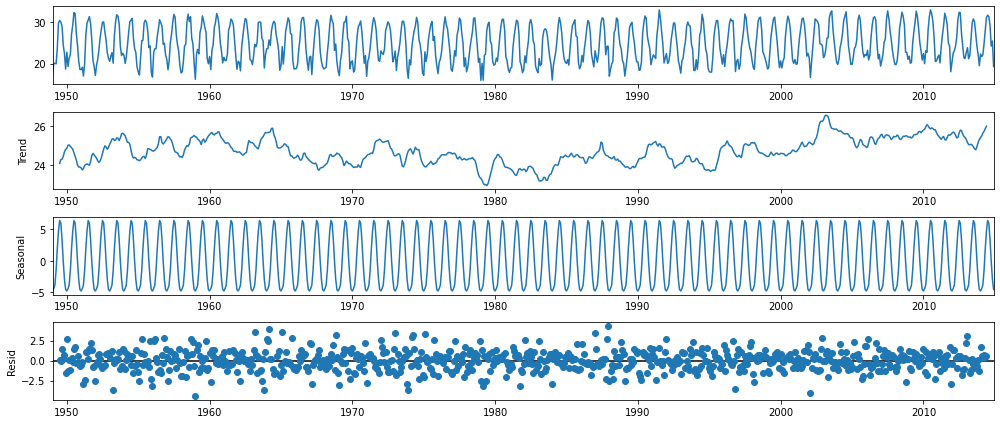

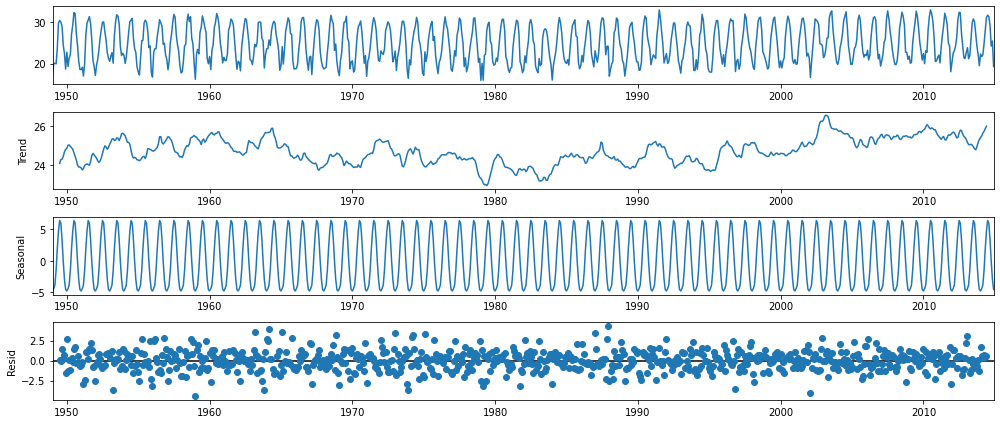

In [12]:
result = seasonal_decompose(df[['MEAN']], model='additive', period=12)
result.plot()

In [13]:
plot_plotly(df.loc[df['YEAR']>2010,['MEAN']],'Temperature in 2010-2015')

In [14]:
plot_plotly(df.groupby('YEAR')['MEAN'].mean(), 'Mean temperature through the years')

In [15]:
df['MEAN'].iplot(kind='hist', xTitle='temperature',
                  yTitle='counts', title='Temperature Distribution through all period 1949-2015 in Murmansk')

Apply ARIMA model, which will check coefficients and choose the best one (smaller AIC)

In [16]:
stepwise_model = auto_arima(df[['MEAN']], start_p=0, start_q=0,
                           max_p=6, max_q=6, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3612.239, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3271.832, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3441.782, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3157.740, Time=0.59 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.32 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.87 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=3320.571, Time=0.44 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=3067.524, Time=0.91 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=3186.736, Time=0.45 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=4.59 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.61 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=3029.236, Time=0.93 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=3144.7

We got best result Best model: ARIMA(6,1,0)(2,1,0)[12]    

AIC=2983

Get train and test data

In [17]:
train = df[['MEAN']]
test = df_test[['MEAN']]

In [18]:
test

,MEAN
index,
2015-01-01,19.677419
2015-02-01,19.882143
2015-03-01,20.751613
2015-04-01,22.390000
2015-05-01,24.545161
2015-06-01,29.083333
2015-07-01,31.322581
2015-08-01,30.870968
2015-09-01,29.143333


In [19]:
stepwise_model.fit(train)

ARIMA(order=(6, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [20]:
future_forecast = stepwise_model.predict(n_periods=12)

In [21]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
future_forecast['Prediction']=future_forecast['Prediction']-20
test=test-20

In [22]:
plot_plotly(pd.concat([test,future_forecast],axis=1),'Predicted temperature in 2015')

Scores for prediction

In [23]:
rmse = sqrt(mean_squared_error(test, future_forecast))
r2 = r2_score(test,future_forecast)
print('Test RMSE: %.3f' % rmse)
print('Test R2: %.3f' % r2)

Test RMSE: 2.132
Test R2: 0.755
